
# Example of High Gamma Filter

Below is a code sample for extracting high gamma power from a raw data file, followed by permutation cluster stats on that high gamma power data


In [199]:
import ieeg.viz.utils
from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.calc import stats, scaling
from ieeg.process import parallelize
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale
from misc_functions import calculate_RTs


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from bids import BIDSLayout
import mne
import os
import numpy as np

import pickle

In [200]:
def relabel_axes(old_min, old_max, new_min, new_max):
    scale = (new_max - new_min) / (old_max - old_min)

    def format_func(value, tick_number):
        return new_min + value * scale

    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

### grab the data and set up variables

In [229]:
HOME = os.path.expanduser("~")

# get box directory depending on OS
if os.name == 'nt': # windows
    LAB_root = os.path.join(HOME, "Box", "CoganLab")
else: # mac
    LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box", "CoganLab")

layout = get_data("GlobalLocal", root=LAB_root)


print(layout.derivatives)
print(layout.derivatives.keys())

# raw = raw_from_layout(layout, subject=sub,
#                         extension='.edf', preload=True)
subjects = layout.get(return_type="id", target="subject")
for sub in subjects:

    filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                            extension='.edf', desc='clean', preload=False) #get line-noise filtered data

    save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


    # do filtering now
    ## Crop raw data to minimize processing time
    good = crop_empty_data(filt)

    ## remove bad channels
    good.info['bads'] = channel_outlier_marker(good, 3, 2)
    good.drop_channels(good.info['bads'])
    good.load_data()

    # CAR
    ch_type = filt.get_channel_types(only_data_chs=True)[0]
    good.set_eeg_reference(ref_channels="average", ch_type=ch_type)


    # make baseline 
    # make stimulus baseline EpochsTFR
    times=[-1, 0.5]
    trials = trial_ieeg(good, "Stimulus", times, preload=True)
    outliers_to_nan(trials, outliers=10) #this removes trial outliers BUT breaks the shape because different stimulus epochs will then have different trial numbers
    HG_base = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_base, "0.5s")

    data_dict = {}  # make something to store all the outputs

    for event, t in zip(("Stimulus", "Response"), ((-1, 1.5), (-1, 1.5))):
        times = [None, None]
        times[0] = t[0] - 0.5
        times[1] = t[1] + 0.5
        trials = trial_ieeg(good, event, times, preload=True)
        outliers_to_nan(trials, outliers=10)
        HG_ev1 = gamma.extract(trials, copy=False, n_jobs=1)
        crop_pad(HG_ev1, "0.5s")

        HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore')
        # HG_ev1.resample(100)
        # HG_ev1.filenames = good.filenames

        # Store the variable in the dictionary with the desired name
        data_dict[f"HG_ev1_{event}"] = HG_ev1
        data_dict[f"HG_ev1_{event}_rescaled"] = HG_ev1_rescaled
        
    resp_evoke = data_dict["HG_ev1_Response"].average(method=lambda x: np.nanmean(x, axis=0))
    resp_evoke_rescaled = data_dict["HG_ev1_Response_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))
    stim_evoke = data_dict["HG_ev1_Stimulus"].average(method=lambda x: np.nanmean(x, axis=0))
    stim_evoke_rescaled = data_dict["HG_ev1_Stimulus_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))

    RTs, skipped = calculate_RTs(good)
    avg_RT = np.median(RTs)

    # Plot the evoked data
    fig = resp_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))  # 1 because z-score is unit-less and requires no scaling
    fig.savefig(save_dir + '_HG_ev1_Response_zscore_rt.png')

    fig = stim_evoke_rescaled.plot(unit=False, scalings=dict(sEEG=1))  # 1 because z-score is unit-less and requires no scaling
    # Add a vertical line indicating the average reaction time to the plot
    for ax in fig.axes:
        ax.axvline(x=avg_RT, color='r', linestyle='--')
        
    fig.savefig(save_dir + '_HG_ev1_Stimulus_zscore_rt.png')

    # # decimate for stats
    # resp = data_dict["HG_ev1_Response"] #i think it shouldn't be the rescaled data because that is already divided by baseline, right? So it shouldn't be significantly different than baseline.
    # stim = data_dict["HG_ev1_Stimulus"]
    # HG_base.decimate(2)
    # resp.decimate(2)
    # stim.decimate(2)

    # # do permutation cluster
    # resp_mask = stats.time_perm_cluster(resp._data, HG_base._data, 0.05, axis=0,
    #                             n_perm=1000, n_jobs=6, ignore_adjacency=1)
    # stim_mask = stats.time_perm_cluster(stim._data, HG_base._data, 0.05, axis=0,
    #                             n_perm=1000, n_jobs=6, ignore_adjacency=1)
    
    # # plot stats
    # plt.figure(figsize=(16, 8))  # Adjust the width and height as needed
    # plt.imshow(stim_mask, aspect='auto')  # hold on from matlab
    # relabel_axes(0, 2500, -1000, 1500)
    # plt.savefig(save_dir + '_stimulus_stats_big.png', dpi=300)

    # plt.figure(figsize=(16, 8))
    # plt.imshow(resp_mask, aspect='auto')
    # relabel_axes(0, 2500, -1000, 1500)
    # plt.savefig(save_dir + '_response_stats_big.png', dpi=300)



{'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24}
KeysView({'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24})
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


### for testing with a single subject

{'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24}
KeysView({'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24})
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.t

c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0059\ieeg\sub-D0059_acq-01_space-ACPC_electrodes.tsv.


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (185) does not match the number of channels in the raw data file (184). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


outlier round 1 channels: ['LAIP9']
outlier round 1 channels: ['LAIP9', 'LAIP14']
outlier round 1 channels: ['LAIP9', 'LAIP14', 'LMMT2']
outlier round 1 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12']
outlier round 1 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10']
outlier round 1 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10', 'LMPT11']
outlier round 2 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10', 'LMPT11', 'LMPF15']
outlier round 2 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10', 'LMPT11', 'LMPF15', 'LMMT1']
outlier round 2 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10', 'LMPT11', 'LMPF15', 'LMMT1', 'LMMT3']
outlier round 2 channels: ['LAIP9', 'LAIP14', 'LMMT2', 'LMMT12', 'LMPT10', 'LMPT11', 'LMPF15', 'LMMT1', 'LMMT3', 'LMMT11']
Reading 0 ... 3242460  =      0.000 ...  1583.232 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Respo

100%|██████████| 448/448 [04:54<00:00,  1.52it/s]


Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75']
event_ids: {'c25/r25': 21, 'c25/r75': 22, 'c25/s25': 23, 'c25/s75': 24, 'c75/n25': 25, 'c75/r25': 26, 'c75/r75': 27, 'c75/s25': 28, 'c75/s75': 29, 'i25/n25': 30, 'i25/n

100%|██████████| 448/448 [09:31<00:00,  1.28s/it]


Applying baseline correction (mode: zscore)
Used Annotations descriptions: ['Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/n25', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/n25', 'Response/i25/n75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/n25', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n25', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75']
event_ids: {'c25/r25': 1, 'c25/r75': 2, 'c25/s25': 3, 'c25/s75': 4, 'c75/n25': 5, 'c75/r25': 6, 'c75/r75': 7, 'c75/s25': 8, 

100%|██████████| 447/447 [09:18<00:00,  1.25s/it]


Applying baseline correction (mode: zscore)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


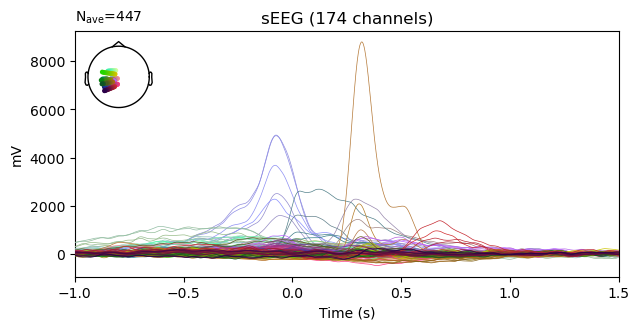

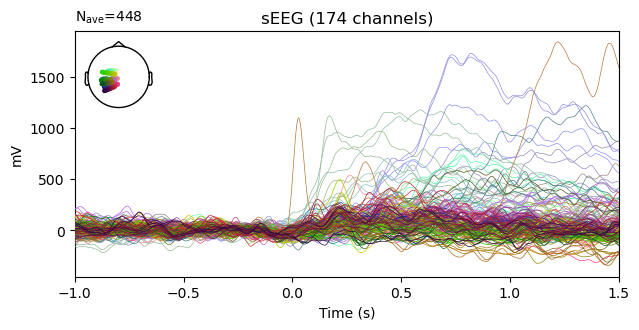

In [222]:
HOME = os.path.expanduser("~")

# get box directory depending on OS
if os.name == 'nt': # windows
    LAB_root = os.path.join(HOME, "Box", "CoganLab")
else: # mac
    LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box", "CoganLab")

layout = get_data("GlobalLocal", root=LAB_root)



print(layout.derivatives)
print(layout.derivatives.keys())

# raw = raw_from_layout(layout, subject=sub,
#                         extension='.edf', preload=True)
subjects = layout.get(return_type="id", target="subject")
sub = 'D0059'

filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                        extension='.edf', desc='clean', preload=False) #get line-noise filtered data

save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', 'figs', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# do filtering now
## Crop raw data to minimize processing time
good = crop_empty_data(filt)

## remove bad channels
good.info['bads'] = channel_outlier_marker(good, 3, 2)
good.drop_channels(good.info['bads'])
good.load_data()

# CAR
ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)


# make baseline 
# make stimulus baseline EpochsTFR
times=[-1, 0.5]

trials = trial_ieeg(good, "Stimulus", times, preload=True)
outliers_to_nan(trials, outliers=10)
HG_base = gamma.extract(trials, copy=False, n_jobs=1)
crop_pad(HG_base, "0.5s")

data_dict = {}  # Create an empty dictionary

for event, t in zip(("Stimulus", "Response"), ((-1, 1.5), (-1, 1.5))):
    times = [None, None]
    times[0] = t[0] - 0.5
    times[1] = t[1] + 0.5
    trials = trial_ieeg(good, event, times, preload=True)
    outliers_to_nan(trials, outliers=10)
    HG_ev1 = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")

    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='zscore') #removed .average() part. Check with Aaron if this is okay.
    # HG_ev1.resample(100)
    # HG_ev1.filenames = good.filenames

    # Store the variable in the dictionary with the desired name
    data_dict[f"HG_ev1_{event}"] = HG_ev1
    data_dict[f"HG_ev1_{event}_rescaled"] = HG_ev1_rescaled

resp_evoke = data_dict["HG_ev1_Response"].average(method=lambda x: np.nanmean(x, axis=0))
resp_evoke_rescaled = data_dict["HG_ev1_Response_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))
stim_evoke = data_dict["HG_ev1_Stimulus"].average(method=lambda x: np.nanmean(x, axis=0))
stim_evoke_rescaled = data_dict["HG_ev1_Stimulus_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))

RTs, skipped = calculate_RTs(good)
avg_RT = np.median(RTs)

# Plot the evoked data
fig = resp_evoke_rescaled.plot()


# fig.savefig(save_dir + '_HG_ev1_Response_rescaled_zscore_test.png')

fig = stim_evoke_rescaled.plot()
# Add a vertical line indicating the average reaction time to the plot
for ax in fig.axes:
    ax.axvline(x=avg_RT, color='r', linestyle='--')

fig.savefig(save_dir + '_HG_ev1_Stimulus_test.png')

# # decimate for stats
# resp = data_dict["HG_ev1_Response"] #i think it shouldn't be the rescaled data because that is already divided by baseline, right? So it shouldn't be significantly different than baseline.
# stim = data_dict["HG_ev1_Stimulus"]
# HG_base.decimate(2)
# resp.decimate(2)
# stim.decimate(2)

# # import scipy
# resp_mask = stats.time_perm_cluster(resp._data, HG_base._data, 0.05, axis=0,
#                             n_perm=1000, n_jobs=6, ignore_adjacency=1)
# stim_mask = stats.time_perm_cluster(stim._data, HG_base._data, 0.05, axis=0,
#                             n_perm=1000, n_jobs=6, ignore_adjacency=1)

# # plot stats
# plt.figure(figsize=(16, 8))  # Adjust the width and height as needed
# plt.imshow(stim_mask, aspect='auto')
# # hold on from matlab
# # plt.imshow(x) #plot multiple things like this

# relabel_axes(0, 2500, -1000, 1500)
# plt.savefig(save_dir + '_stimulus_stats_big.png', dpi=300)

# plt.figure(figsize=(16, 8))  # Adjust the width and height as needed
# plt.imshow(resp_mask, aspect='auto')
# relabel_axes(0, 2500, -1000, 1500)
# plt.savefig(save_dir + '_response_stats_big.png', dpi=300)
